#[Detecting the difficulty level of French texts](https://www.kaggle.com/c/detecting-the-difficulty-level-of-french-texts/overview/evaluation)
## First approach
---
In this notebook, we will try differents classification models with very basic text cleaning and no hyper-parameters tuning. This will allow us to have a baseline and to select the most promising models for further study.

## Imports

In [ ]:
# Download the french spacy model
!python -m spacy download fr_core_news_md

In [11]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import spacy
from spacy import displacy
import string
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')
np.random.seed = 0

def evaluate(y_true, pred):
  """
  Calculate the models performance metrics. 
  Since it is a multi-class classification, we take the weighted average 
  for the metrics that are calculated for each class.

  """

  report = {
      'accuracy':accuracy_score(y_true, pred),
      'recall':recall_score(y_true, pred, average='macro'),
      'precision':precision_score(y_true, pred, average='macro'),
      'f1_score':f1_score(y_true, pred, average='macro')
  }

  return report

def plot_confusion_matrix(y_true, pred, model):
  
  """
  A function to plot the models confusion matrix.
  """

  cf_matrix = confusion_matrix(y_test, pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=model.classes_)
    
  disp.plot()


reports = {}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/LaCrazyTomato/Group-Project-DM-ML-2021/main/data/training_data.csv")
unlabeled_df = pd.read_csv("https://raw.githubusercontent.com/LaCrazyTomato/Group-Project-DM-ML-2021/main/data/unlabelled_test_data.csv")

display(df.head())
display(unlabeled_df.head())


,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


# 2. Tokenizer & vectorizer


In [4]:
# Define cleaning function
def nltk_tokenizer(doc):

    # Tokenize
    doc = word_tokenize(doc)

    # Remove uppercase and white spaces
    doc = [word.lower().strip() for word in doc]
    
    return doc


print(nltk_tokenizer(df.loc[2, 'sentence']))

['le', 'test', 'de', 'niveau', 'en', 'français', 'est', 'sur', 'le', 'site', 'internet', 'de', "l'école", '.']


We selected a TFIDF vectorizer because it gives more importance to rare words and we believe that a rare word can be a sign of complexity.

In [5]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=nltk_tokenizer)

# 3. Classification
We are now ready to test the different classification models. We will start with the ones we have seen in class and then we will try others provided by Sklearn.

In [6]:
# Select features
X = df['sentence']
y = df['difficulty']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_train

183     Vous attendîtes la surprise que vos parents vo...
90                      Le petit chat a plu à mes parents
1128    Pourfendeur des sciences et des arts, fossoyeu...
2336    un berger est une personne chargée de guider e...
4398    Pendant les trois années d'études, je vivais d...
                              ...                        
3983    La Corse est une petite île au sud de la Franc...
1870                             Ma mère s'appelle Marie.
394     Le journaliste lui a posé des questions auxque...
3244    Les sentiments de l'homme sont confus et mélan...
411     Il n'engendre aucun mouvement alternatif, ce q...
Name: sentence, Length: 3840, dtype: object

## Logistic Regression

In [7]:
# Define classifier
LR_model = LogisticRegression()

LR_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', LR_model)])

LR_pipe.fit(X_train, y_train)

pred = LR_pipe.predict(X_test)

LR_report = evaluate(y_test, pred)

# Store model performance results
reports['Logistic Regression'] = LR_report

LR_report

{'accuracy': 0.47291666666666665,
 'f1_score': 0.4664396688704459,
 'precision': 0.46877502680753586,
 'recall': 0.4718692027845621}

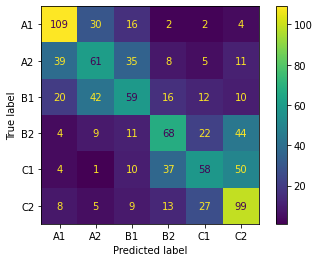

In [12]:
plot_confusion_matrix(y_test, pred, LR_pipe)

Let's look at some errors to maybe understand better why the model gets it wrong.

In [ ]:
badly_predicted = pd.DataFrame({'sentence':X_test[pred != y_test],
              'predicted':pred[pred != y_test],
              'true':y_test[pred != y_test]})


for i, row in badly_predicted.sample(3).iterrows():
    print(row.sentence)
    print(f"Predicted: {row.predicted}")
    print(f"Actual: {row.true}")



Je pense que fréquenter les galeries est la meilleure manière d'éduquer son oeil à l'art contemporain.
Predicted: A2
Actual: B2
Si tu pars en vacances avec nous, je serais ravie.
Predicted: A1
Actual: B1
Je vais étudier l'anglais
Predicted: A2
Actual: A1


Hard to tell where the errors comes from.. Probably the vectorizer has to be tuned.

## kNN

In [13]:
knn_model = KNeighborsClassifier()

knn_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', knn_model)])


knn_pipe.fit(X_train, y_train)

pred = knn_pipe.predict(X_test)

knn_report = evaluate(y_test, pred)

# Store model performance results
reports['kNN'] = knn_report


knn_report

{'accuracy': 0.35104166666666664,
 'f1_score': 0.32624310727699596,
 'precision': 0.39461812640832467,
 'recall': 0.3490178912029139}

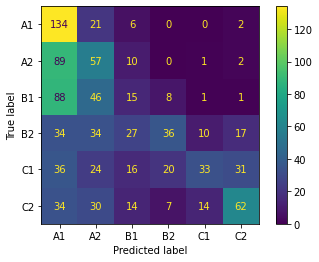

In [14]:
plot_confusion_matrix(y_test, pred, knn_pipe)

## Decision Tree

In [15]:
tree_model = DecisionTreeClassifier()

tree_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', tree_model)])


tree_pipe.fit(X_train, y_train)

pred = tree_pipe.predict(X_test)

tree_report = evaluate(y_test, pred)

# Store model performance results
reports['Decision Tree'] = tree_report

tree_report

{'accuracy': 0.3072916666666667,
 'f1_score': 0.3019538636010634,
 'precision': 0.3040673712896869,
 'recall': 0.3064749332040397}

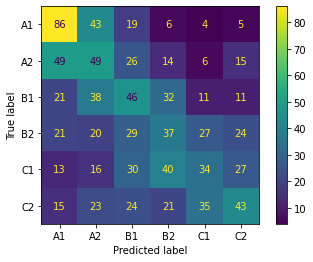

In [16]:
plot_confusion_matrix(y_test, pred, tree_pipe)

## Random Forest

In [18]:
forest_model = RandomForestClassifier()

forest_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', forest_model)])

forest_pipe.fit(X_train, y_train)

pred = forest_pipe.predict(X_test)

forest_report = evaluate(y_test, pred)

# Store model performance results
reports['Random Forest'] = forest_report

forest_report

{'accuracy': 0.39479166666666665,
 'f1_score': 0.3790089351954125,
 'precision': 0.39071638637400535,
 'recall': 0.3933887974080712}

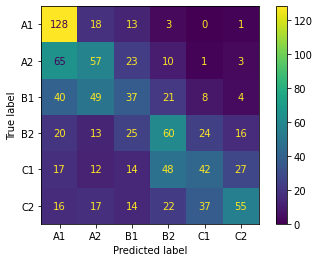

In [19]:
plot_confusion_matrix(y_test, pred, forest_pipe)

## Ridge classifier

In [20]:
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier()

ridge_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', ridge_model)])


ridge_pipe.fit(X_train, y_train)

pred = ridge_pipe.predict(X_test)

ridge_report = evaluate(y_test, pred)

# Store model performance results
reports['Ridge Classifier'] = ridge_report

ridge_report

{'accuracy': 0.46770833333333334,
 'f1_score': 0.45972747970980904,
 'precision': 0.4615182094256809,
 'recall': 0.4665687341851987}

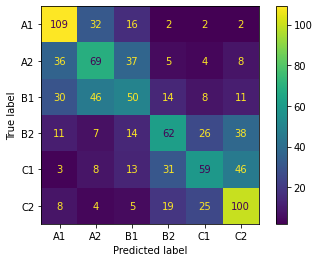

In [21]:
plot_confusion_matrix(y_test, pred, ridge_pipe)

## Perceptron classifier

In [22]:
from sklearn.linear_model import Perceptron

perceptron_model = Perceptron()

perceptron_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                 ('classifier', perceptron_model)])


perceptron_pipe.fit(X_train, y_train)

pred = perceptron_pipe.predict(X_test)

perceptron_report = evaluate(y_test, pred)

# Store model performance results
reports['Perceptron Classifier'] = perceptron_report

perceptron_report


{'accuracy': 0.41041666666666665,
 'f1_score': 0.40604218573199513,
 'precision': 0.41168058805580104,
 'recall': 0.40951390689663025}

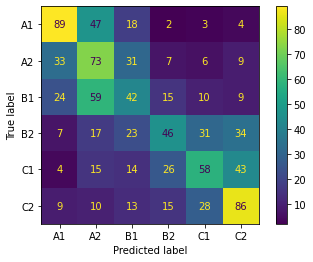

In [23]:
plot_confusion_matrix(y_test, pred, perceptron_pipe)

# Select best models

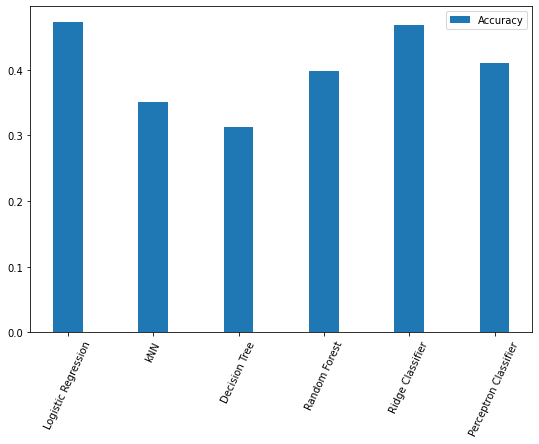

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))

width = 0.35
labels = reports.keys()

ax.bar(labels, [x['accuracy'] for x in reports.values()], 
        label='Accuracy', width=width)

plt.xticks(rotation=65)
ax.legend()


We will remove kNN as it shows an accuracy a lot smaller than others models.

We will keep Random Forest since Decision Tree alone is not sufficient.

Now, let's focus on these 4 models and try to find their optimal parameters !

